#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
! pip install lightgbm

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, make_scorer

In [3]:
data = pd.read_csv('/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)

Произведем ресемплирование, для этого устоновим новое значение временного ряда в 1 час.

In [4]:
data = data.resample('1H').sum()

## Анализ

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


DataFrame содержит 4416 объектов с одним признаком без пропущенных значений.

In [ ]:
data.tail(10)

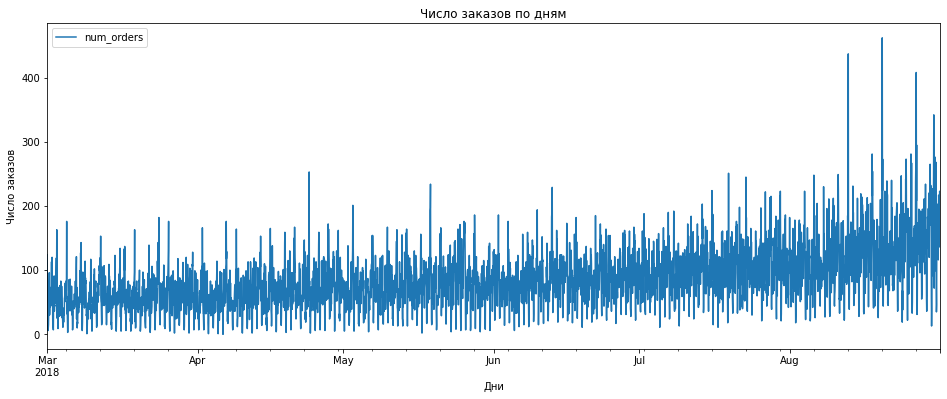

In [7]:
data.plot(figsize=(16, 6))
plt.title('Число заказов по дням')
plt.ylabel('Число заказов')
plt.xlabel('Дни')
plt.show()

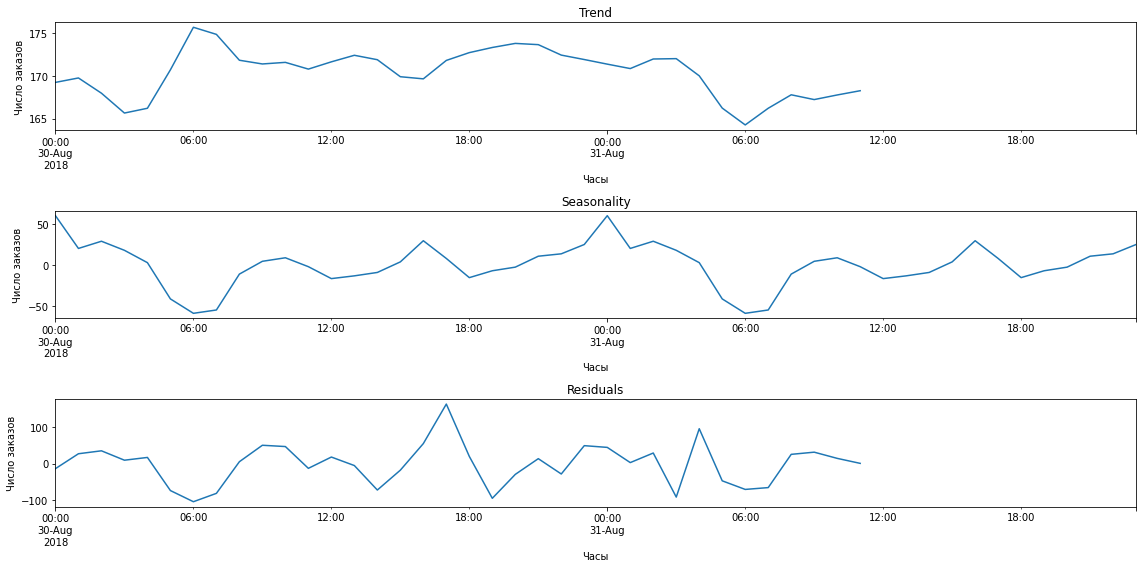

In [8]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(16, 8))

plt.subplot(311)
decomposed.trend['2018-08-30':'2018-08-31'].plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Число заказов')
plt.xlabel('Часы')

plt.subplot(312)
decomposed.seasonal['2018-08-30':'2018-08-31'].plot(ax = plt.gca())
plt.title('Seasonality')
plt.ylabel('Число заказов')
plt.xlabel('Часы')

plt.subplot(313)
decomposed.resid['2018-08-30':'2018-08-31'].plot(ax=plt.gca())# < напишите код здесь >
plt.title('Residuals')
plt.ylabel('Число заказов')
plt.xlabel('Часы')

plt.tight_layout()
plt.show()

Мы можем увидеть пики заказов: максимальный в 00:00 и минимальный 06:00

Добавим новые признаки

In [9]:
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour

In [10]:
for lag in range(1, 24, 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
data['rolling_mean'] = data['num_orders'].shift().rolling(48).mean()
data = data.dropna()

In [ ]:
data.describe()

## Обучение

In [12]:
def RMSE(target, predicted):
    return mean_squared_error(target, predicted) ** .5
scorer = make_scorer(RMSE, greater_is_better = False)

Разделим выборки на тестовую и тренировочную и подберем параметры модели.

In [13]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [14]:
features_train = train.drop(['num_orders'], axis = 1)
target_train =  train['num_orders']

In [15]:
 tscv = TimeSeriesSplit(n_splits=9)

In [16]:
model = LinearRegression()

scores = cross_val_score(model, features_train, target_train, scoring = scorer, cv=tscv)
final_score = sum(scores)/len(scores)

print('Средняя оценка RMSE:', final_score * (-1))

Средняя оценка RMSE: 28.922948063214147


In [17]:
%%time

clf = RandomForestRegressor()
parametrs = {'n_estimators': range(1, 151, 30),
            'max_depth': range(1,31,3)}
grid = GridSearchCV(estimator=clf, cv=tscv, param_grid=parametrs , scoring = scorer)
grid.fit(features_train, target_train)
print(grid.best_params_)    
print(grid.best_score_)

{'max_depth': 19, 'n_estimators': 121}
-24.24004711373229
CPU times: user 9min 27s, sys: 1.88 s, total: 9min 29s
Wall time: 9min 31s


In [18]:
%%time

clf = LGBMRegressor()
parametrs = {'n_estimators': range(10, 51, 10),
            'max_depth': range(1,11,1)}
grid = GridSearchCV(clf, parametrs, scoring=scorer, cv=tscv)
grid.fit(features_train, target_train)
print(grid.best_params_)    
print(grid.best_score_)

{'max_depth': 8, 'n_estimators': 50}
-24.20736337519081
CPU times: user 11min 12s, sys: 4.46 s, total: 11min 16s
Wall time: 11min 23s


In [19]:
%%time

clf = GradientBoostingRegressor()
grid = GridSearchCV(clf, parametrs, scoring=scorer, cv=tscv)
grid.fit(features_train, target_train)
print(grid.best_params_)    
print(grid.best_score_)

{'max_depth': 6, 'n_estimators': 40}
-24.710880133160167
CPU times: user 3min 36s, sys: 273 ms, total: 3min 36s
Wall time: 3min 37s


## Тестирование

Обучим модель с лучшими параметрами и проверим на тестовой выборке.

In [20]:
features_test = test.drop(['num_orders'], axis = 1)
target_test =  test['num_orders']

<a class="anchor" id="21-bullet"></a> 

In [21]:
model =  RandomForestRegressor(max_depth = 19, n_estimators = 121)   
model.fit(features_train, target_train)
predictions = model.predict(features_test)
print('оценка RMSE:', RMSE(target_test, predictions))

оценка RMSE: 43.173215900682166


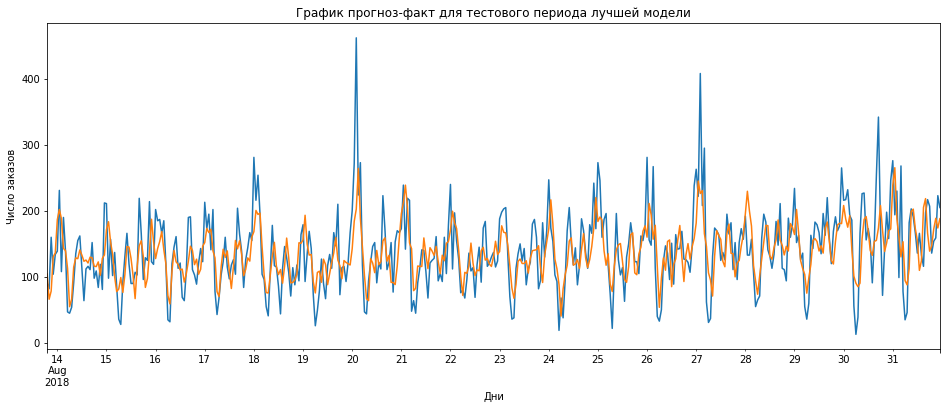

In [23]:
target_test.plot(figsize=(16, 6))
series = pd.Series(predictions, index=target_test.index) .plot()
plt.title('График прогноз-факт для тестового периода лучшей модели')
plt.ylabel('Число заказов')
plt.xlabel('Дни')
plt.show()

In [24]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train)
dummy =dummy_regr.predict(features_test)
print('оценка RMSE:', RMSE(target_test, dummy))

оценка RMSE: 84.73905254961741


# Вывод: 
Мы построили модель с минимальным значением RMSE. Модель проверена на тестовой выборке.